In [1]:
# NOTE: This code block _must_ be run before any others, so the rest of the program has something to work with.

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# load data for Bernalillo County and set some variables
bern_co_pop = 677858 # manually retrieved from data.census.gov on 02/13/2021
bern_co_covid_url = 'https://e7p503ngy5.execute-api.us-west-2.amazonaws.com/prod/GetCountyDataByDay?countyId=1'
bern_co_json = requests.get(bern_co_covid_url).json()["data"]
bern_co_data = pd.json_normalize(bern_co_json)

# separate out the data we need, and do math to get daily totals
bern_co_data_min = bern_co_data[["date", "cases", "tests", "deaths"]].copy()
bern_co_data_daily = bern_co_data[["cases", "tests", "deaths"]].copy().diff()
bern_co_data_daily.loc[:, "date"] = bern_co_data[["date"]].copy()
bern_co_data_daily = bern_co_data_daily.reindex(columns=["date", "cases", "tests", "deaths"])

## Plotting Existing Data

The following four sections plot case and test data for the past four weeks (note that this a longer time period than is analyzed below for the Red-to-Green Framework, but we get more context this way).

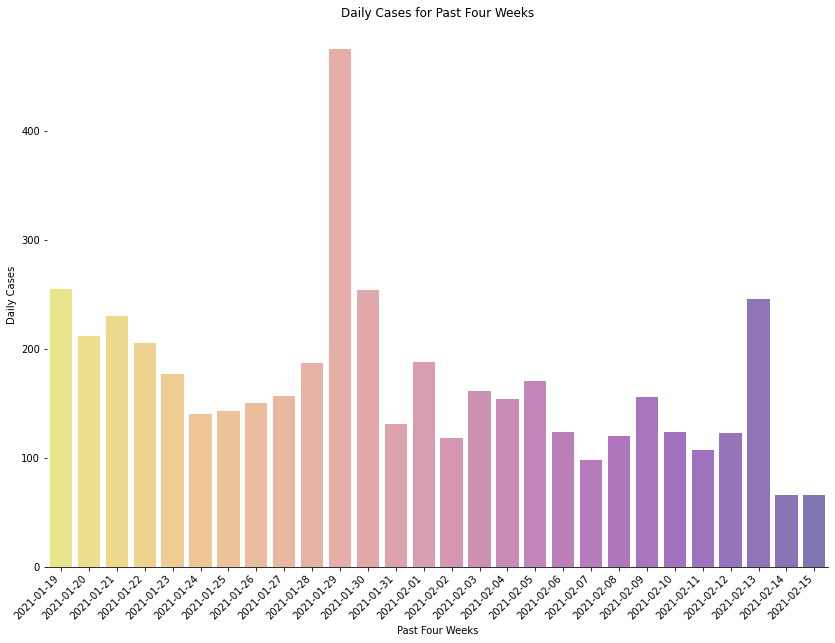

In [2]:
plt.figure(figsize=(14,10))
cases_plot = sns.barplot(x='date', y='cases', data=bern_co_data_daily[-28:], palette = 'plasma_r', alpha=0.6)
cases_plot.set_xlabel('Past Four Weeks')
cases_plot.set_ylabel('Daily Cases')
cases_plot.set_title ('Daily Cases for Past Four Weeks')
cases_plot.set_xticklabels(cases_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.despine(left=True)

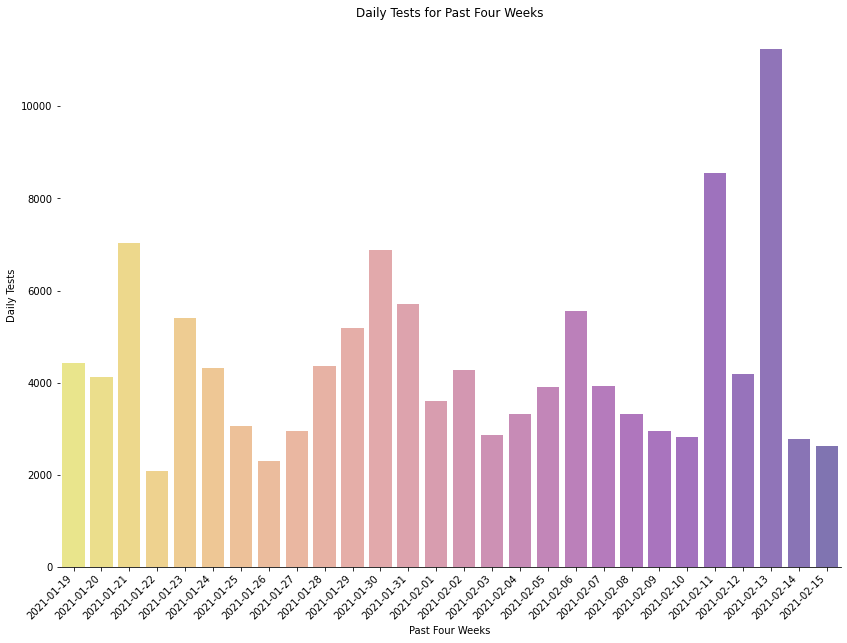

In [3]:
plt.figure(figsize=(14,10))
tests_plot = sns.barplot(x='date', y='tests', data=bern_co_data_daily[-28:], palette = 'plasma_r', alpha=0.6)
tests_plot.set_xlabel('Past Four Weeks')
tests_plot.set_ylabel('Daily Tests')
tests_plot.set_title ('Daily Tests for Past Four Weeks')
tests_plot.set_xticklabels(tests_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.despine(left=True)

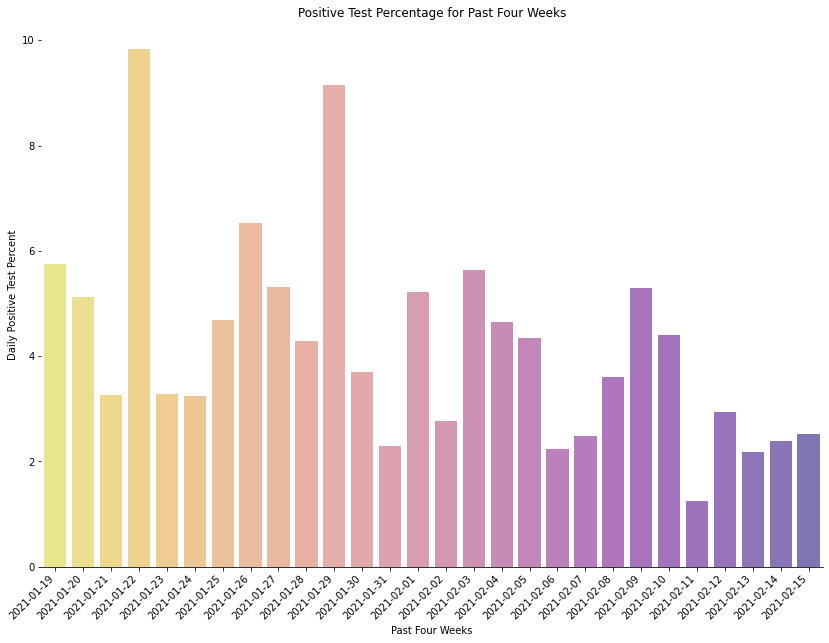

In [4]:
bern_co_data_daily["positive_test_percentage"] = \
    bern_co_data_daily.apply(lambda row: 0.00 if row.tests == 0 else
                             row.cases/row.tests*100.0, axis = 1)

plt.figure(figsize=(14,10))
percent_plot = sns.barplot(x='date', y='positive_test_percentage', data=bern_co_data_daily[-28:], palette = 'plasma_r', alpha=0.6)
percent_plot.set_xlabel('Past Four Weeks')
percent_plot.set_ylabel('Daily Positive Test Percent')
percent_plot.set_title ('Positive Test Percentage for Past Four Weeks')
percent_plot.set_xticklabels(percent_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.despine(left=True)

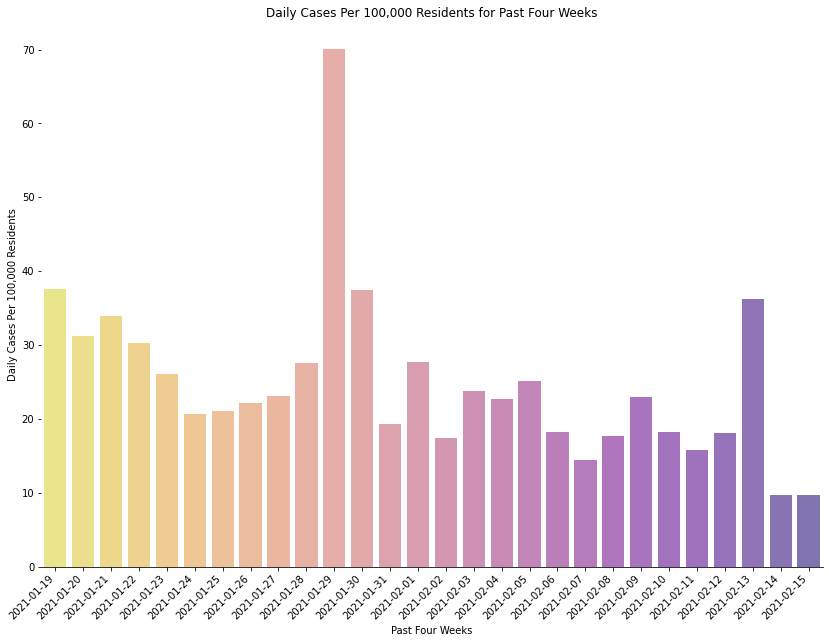

In [5]:
bern_co_data_daily["cases_per_100k"] = \
    bern_co_data_daily.apply(lambda row: row.cases*100000/bern_co_pop, axis = 1)

plt.figure(figsize=(14,10))
cases_100k_plot = sns.barplot(x='date', y='cases_per_100k', data=bern_co_data_daily[-28:], palette = 'plasma_r', alpha=0.6)
cases_100k_plot.set_xlabel('Past Four Weeks')
cases_100k_plot.set_ylabel('Daily Cases Per 100,000 Residents')
cases_100k_plot.set_title ('Daily Cases Per 100,000 Residents for Past Four Weeks')
cases_100k_plot.set_xticklabels(cases_100k_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.despine(left=True)

## Current Status and Restrictions

This last section analyzes data from the past two weeks to determine the percentage of positive tests within Bernalillo County as well as the average number of positive test cases per 100,000 residents per day, then uses these two statistics to determine Bernalillo County's current status according to New Mexico's [Red-to-Green Framework](https://cv.nmhealth.org/public-health-orders-and-executive-orders/red-to-green/). It then prints the two statistics, Bernalillo County's current status in the Red-to-Green Framework, and what restrictions should currently be in place (per the NM DOH).

In [6]:
total_cases_two_weeks = bern_co_data_min.iloc[-1]["cases"] - bern_co_data_min.iloc[-15]["cases"]
total_tests_two_weeks = bern_co_data_min.iloc[-1]["tests"] - bern_co_data_min.iloc[-15]["tests"]
percent_positive_two_weeks = total_cases_two_weeks/total_tests_two_weeks*100.0
average_cases_per_100k_two_weeks = total_cases_two_weeks/14*100000/bern_co_pop
current_date = bern_co_data_min.iloc[-1]["date"]

print("As of %s:" % current_date)
print("%.2f percent of tests for the past two weeks have come back positive." % percent_positive_two_weeks)
print("There has been an average of %d positive cases per 100,000 residents per day for the past two weeks." % average_cases_per_100k_two_weeks)

current_status = ""
current_restrictions = []
if percent_positive_two_weeks < 5.0 and average_cases_per_100k_two_weeks < 8.0:
    current_status = "GREEN"
    current_restrictions = [
        "Essential businesses (non-retail): No capacity restrictions but must limit operations to only those absolutely necessary to carry out essential functions",
        "Essential retail spaces: 25% of maximum capacity",
        "Food and drink establishments: No indoor dining permitted; 25% of maximum capacity for outdoor dining; any establishment serving alcohol must close by 9 p.m. each night",
        "Close-contact businesses: 25% of maximum capacity or 10 customers at one time, whichever is smaller",
        "Outdoor recreational facilities: 25% of maximum capacity (unless required to have less capacity under the state’s COVID-Safe Practices)",
        "Close-contact recreational facilities: Remain closed",
        "All other businesses: 25% of maximum capacity or 75 customers at one time, whichever is smaller",
        "Houses of worship: May hold religious services, indoors or outdoors, or provide services through audiovisual means, but may not exceed 25% of the maximum capacity of any enclosed space on the premises",
        "Places of lodging: 40% of maximum occupancy for those that have completed NM Safe Certified training; 25% of maximum occupancy for all others; 5 guests maximum for vacation rentals",
        "Mass gatherings limit: 5 persons, 40 vehicles"
    ]
elif percent_positive_two_weeks < 5.0 or average_cases_per_100k_two_weeks < 8.0:
    current_status = "YELLOW"
    current_restrictions = [
        "Essential businesses (non-retail): No capacity restrictions but operations must be limited to only those absolutely necessary to carry out essential functions",
        "Essential retail spaces: 33% of maximum capacity",
        "Food and drink establishments: 25% of maximum capacity for indoor dining; 75% of maximum capacity for outdoors dining; any establishment serving alcohol must close by 10 p.m. each night",
        "Close-contact businesses: 25% of maximum capacity or 20 customers at one time, whichever is smaller",
        "Outdoor recreational facilities: 25% of maximum capacity (unless required to have less capacity under the state’s COVID-Safe Practices)",
        "Close-contact recreational facilities: Remain closed",
        "All other businesses: 25% of maximum capacity or 125 customers at one time, whichever is smaller",
        "Houses of worship: May hold religious services, indoors or outdoors, or provide services through audiovisual means, but may not exceed 33% of the maximum capacity of any enclosed space on the premises",
        "Places of lodging: 60% of maximum occupancy for those that have completed NM Safe Certified training; 25% of maximum occupancy for all others; 5 guests maximum for vacation rentals",
        "Mass gatherings limit: 10 persons, 80 vehicles"
    ]
else:
    current_status = "RED"
    current_restrictions =  [
        "Essential businesses (non-retail): No capacity restrictions but operations must be limited to only those absolutely necessary to carry out essential functions",
        "Essential retail spaces: 50% of maximum capacity",
        "Food and drink establishments: 50% of maximum capacity for indoor dining; 75% of maximum capacity for outdoor dining",
        "Close-contact businesses: 50% of maximum capacity",
        "Outdoor recreational facilities: 50% of maximum capacity (unless required to have less capacity under the state’s COVID-Safe Practices)",
        "Close-contact recreational facilities: Remain closed",
        "All other businesses: 50% of maximum capacity",
        "Houses of worship: May hold religious services, indoors or outdoors, or provide services through audiovisual means, but may not exceed 50% of the maximum capacity of any enclosed space on the premises",
        "Places of lodging: 75% of maximum occupancy for those that have completed NM Safe Certified training; 40% of maximum occupancy for all others; 10 guests maximum for vacation rentals",
        "Mass gatherings limit: 20 persons, 120 vehicles"
    ]

print("Based on the above data, Bernalillo County's current status in the Red-to-Green framework is %s and the following restrictions should be in place:" % current_status)
for current_restriction in current_restrictions:
    print("\t" + current_restriction)

As of 2021-02-15:
2.94 percent of tests for the past two weeks have come back positive.
There has been an average of 19 positive cases per 100,000 residents per day for the past two weeks.
Based on the above data, Bernalillo County's current status in the Red-to-Green framework is YELLOW and the following restrictions should be in place:
	Essential businesses (non-retail): No capacity restrictions but operations must be limited to only those absolutely necessary to carry out essential functions
	Essential retail spaces: 33% of maximum capacity
	Food and drink establishments: 25% of maximum capacity for indoor dining; 75% of maximum capacity for outdoors dining; any establishment serving alcohol must close by 10 p.m. each night
	Close-contact businesses: 25% of maximum capacity or 20 customers at one time, whichever is smaller
	Outdoor recreational facilities: 25% of maximum capacity (unless required to have less capacity under the state’s COVID-Safe Practices)
	Close-contact recreation